In [1]:
import numpy as np
import random
import string
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict, Counter

In [74]:
# with open("allowed_words.txt", "r") as f:
#     allowed_words = f.read().split("\n")
# build dicts all around this, so that we can iterate with our prior, and its still efficient
%store -r word_priority  
allowed_words = word_priority  # yes i know this is horrible practice, because its almost completely unreplicatable (?) but whatever

with open("answer_words.txt", "r") as f:
    answer_words = f.read().split("\n")

In [76]:
# pre-processing step
word_size, np_type = 8, np.uint8
words_len = len(allowed_words[0])
bit_masks = [1 << shift for shift in range(word_size)]

# for masked/packed mode of addressing (each word has its own bit within some element of the array) => 2 indices needed
batched_word_to_idx = {word:(i//word_size,1<<(i%word_size)) for i,word in enumerate(allowed_words)}
batched_idx_to_word = {i:word for word,i in batched_word_to_idx.items()}
batched_arr_size = int(np.ceil(len(allowed_words)/word_size))

# for index-based addressing (each word has its own element in the array) => 1 index needed
word_to_idx = {word:i for i,word in enumerate(allowed_words)}
idx_to_word = {i:word for word,i in word_to_idx.items()}
arr_size = len(allowed_words)

# num letters
num_letters = {word: Counter(word) for word in allowed_words}
max_num_letters = max(max(num_letters.items(), key=lambda x: max(x[1].values()))[1].values()) # => should be 3, but we just use words_len everywhere anyway (simplicity)

# mask, where we pack many booleans into 1 element of the array
batched_pos_let_to_words = [{} for _ in range(words_len)]  # map pos,let -> set of words with let in position pos
batched_greater_let_to_words = [{} for _ in range(words_len)]  # map num,let -> words with >=num occurences of let
batched_less_let_to_words = [{} for _ in range(words_len)]  # map num,let -> words with <=num occurences of let

# indices
pos_let_to_words = [{} for _ in range(words_len)]  # map pos,let -> set of words WITHOUT let in position pos
greater_let_to_words = [{} for _ in range(words_len)]  # map num,let -> words with >num occurences of let
less_let_to_words = [{} for _ in range(words_len)]  # map num,let -> words with <=num occurences of let

for let in tqdm(string.ascii_lowercase):
    for num in range(words_len):  # -> should be named pos or amt or num
        arr_pos = np.zeros(batched_arr_size).astype(np_type)
        arr_greater = np.zeros(batched_arr_size).astype(np_type)
        arr_less = np.zeros(batched_arr_size).astype(np_type)

        pos_words_list = []
        greater_words_list = []
        less_words_list = []
        for word, idx in batched_word_to_idx.items():
            if word[num] == let:
                arr_pos[idx[0]] |= idx[1]
            else:
                pos_words_list.append(word_to_idx[word])

            if num_letters[word][let] > num:
                arr_greater[idx[0]] |= idx[1]
                greater_words_list.append(word_to_idx[word])
            else:
                arr_less[idx[0]] |= idx[1]
                less_words_list.append(word_to_idx[word])
        batched_pos_let_to_words[num][let] = arr_pos
        pos_let_to_words[num][let] = np.array(pos_words_list)

        batched_greater_let_to_words[num][let] = arr_greater
        greater_let_to_words[num][let] = np.array(greater_words_list)

        batched_less_let_to_words[num][let] = arr_less
        less_let_to_words[num][let] = np.array(less_words_list)

100%|████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:03<00:00,  6.85it/s]


In [4]:
class Profiler():
    def __init__(self, gamma=0.99):
        self.prev_time = 0
        self.gamma = gamma
        self.stats = {}  # tracks ewma running average
        self.profile = True
        self.verbose = False

    def benchmark(self, point=None): # not thread safe at all
        if not self.profile:
            return
        if point is not None:
            time_taken = time.perf_counter() - self.prev_time
            if point not in self.stats:
                self.stats[point] = [time_taken, 0]  # avg_time, num_times
            self.stats[point][1] += 1
            self.stats[point][0] = self.stats[point][0]*self.gamma + time_taken*(1-self.gamma)
            if self.verbose:
                print(f"took {time_taken} to reach {point}, ewma={self.stats[point]}")
        self.prev_time = time.perf_counter()

    def __repr__(self):
        sum_avgs = sum([x[0] for x in self.stats.values()])
        sum_time = sum([x[0]*x[1] for x in self.stats.values()])
        ret_str = "point\tpct_avg\tpct_cumulative"
        for point,stat in self.stats.items():
            ret_str += f"\n{point}\t{stat[0]/sum_avgs*100.:.3f}%\t{stat[0]*stat[1]/sum_time*100.:.3f}%"
        return ret_str
g_profiler = Profiler()
g_profiler.profile = False

In [5]:
# some slow helper functions
def bit_count(arr):
    return arr.bit_count()

def bitwise_not(arr):
    return ~arr

vectorized_count = np.vectorize(bit_count)
vectorized_not = np.vectorize(bitwise_not)

In [77]:
class FastWordList():
    def __init__(self, batched=False):
        self.batched = batched
        self.offset = 0 # could set this to like 6, but would only give innaccurate counts for the first call of len 
        self.reset()  # since any step of update_list would zero out those 6 extra fake bits

    def reset(self):
        if self.batched:
            self.remaining_words = vectorized_not(np.zeros(batched_arr_size).astype(np_type))
        else:
            self.remaining_words = np.ones(arr_size).astype(np_type)

    def restore_state(self, prev_remaining):
        self.remaining_words = prev_remaining.copy()

    def copy(self):
        return self.remaining_words.copy()

    def remove(self, word):
        bucket,bit_mask = batched_word_to_idx[word]
        self.remaining_words[bucket] &= ~bit_mask

    def update_list(self, green_letters, lower_bounds, upper_bounds, guess_word, curr_round):
        # want to do the updates that remove the most first
        g_profiler.benchmark()
        #print(green_letters, lower_bounds, upper_bounds)
        self.remove(guess_word)  # if all letters in guess were green/yellow, it wouldnt be removed otherwise (agrees with official implementation)
        if green_letters:
            for let,pos in green_letters:
                if self.batched:
                    self.remaining_words &= batched_pos_let_to_words[pos][let]
                else:
                    self.remaining_words[pos_let_to_words[pos][let]] = 0  # remove words that dont have let in position pos
        g_profiler.benchmark(f"green_letters_{curr_round}")
        if lower_bounds:
            for let,num in lower_bounds.items():  # => we have > num occurences of "let"
                if num == -1:
                    continue
                if self.batched:
                    self.remaining_words &= batched_greater_let_to_words[num][let]
                else:
                    self.remaining_words[less_let_to_words[num][let]] = 0  # rm words that have <= num occurences of let
        g_profiler.benchmark(f"lower_bounds_{curr_round}")
        if upper_bounds:  # generalization of grey letters so should be last
            for let,num in upper_bounds.items():  # => we have <= num occurences of "let " (including 0)
                if self.batched:
                    self.remaining_words &= batched_less_let_to_words[num][let]
                else:
                    self.remaining_words[greater_let_to_words[num][let]] = 0  # remove all words that > num occurences of let
        g_profiler.benchmark(f"upper_bounds_{curr_round}")

    def __contains__(self, word):
        if self.batched:
            bucket,bit_mask = batched_word_to_idx[word]
            return self.remaining_words[bucket] & bit_mask
        else:
            idx = word_to_idx[word]
            return self.remaining_words[idx]
        
    def iter_words(self, sparse=True):  # should be faster in cases where remaining_words is sparse, slower else
        if sparse:  # let client estimate whether or not things are sparse right now
            check_these = np.nonzero(self.remaining_words)[0]
            if self.batched:
                for value in check_these:
                    for bit_mask in bit_masks:
                        if value & bit_mask:
                            yield batched_idx_to_word[(value,bit_mask)]
            else:
                for value in check_these:
                    yield idx_to_word[value]
        else:
            for word in allowed_words:
                if word in self:
                    yield word

    def all_words(self):
        word_list = []
        for word in allowed_words:
            if word in self:
                word_list.append(word)
        return word_list

    def __len__(self):
        if self.batched:
            return vectorized_count(self.remaining_words).sum()
        else:
            return self.remaining_words.sum()

In [95]:
aw_batched = AntiWordle(batched=False)
aw_batched.answer = "aback"
aw_batched.play_word("gyppy")
aw_batched.play_word("bluff")
words_left = aw_batched.remaining_words.all_words()
print(words_left[:min(25,len(words_left))], len(words_left))
print("ayaya" in aw_batched.remaining_words)
words_left_other = list(aw_batched.remaining_words.iter_words())
print(words_left_other[:min(25,len(words_left_other))], len(words_left_other))
print("ayaya" in words_left_other)


['bombo', 'kibbi', 'oxbow', 'zimbi', 'babka', 'abaka', 'abaca', 'bacca', 'combo', 'coomb', 'kabab', 'mamba', 'bizzo', 'dabba', 'bajan', 'bindi', 'ebbed', 'jibba', 'jembe', 'nimbi', 'bibbs', 'xebec', 'jibbs', 'zebec', 'aback'] 674
False
['bombo', 'kibbi', 'oxbow', 'zimbi', 'babka', 'abaka', 'abaca', 'bacca', 'combo', 'coomb', 'kabab', 'mamba', 'bizzo', 'dabba', 'bajan', 'bindi', 'ebbed', 'jibba', 'jembe', 'nimbi', 'bibbs', 'xebec', 'jibbs', 'zebec', 'aback'] 674
False


In [42]:
aw_batched = AntiWordle(batched=False)
aw_batched.answer = "aback"
for i,elem in enumerate(batched_pos_let_to_words[2]["a"]):
    for shift in range(8):
        if elem & (1<<shift):
            assert batched_idx_to_word[(i,1<<shift)][2] == "a"
for word in allowed_words:
    if word[0] == "a":
        w_idx = batched_word_to_idx[word]
        if not (batched_pos_let_to_words[0]["a"][w_idx[0]] & w_idx[1]):
            print(word)
            break   # => no prints means batched_pos_let_to_words is accurate

# print(aw_batched.remaining_words.all_words())
aw_batched.play_word("abaca")
print(aw_batched.remaining_words.all_words())   # => should print ['aback'] only
print(len(aw_batched.remaining_words))
aw_batched.play_word("abase") # => should lock in the fact that our next guess needs to start with 'aba'
print(len(aw_batched.remaining_words))  # => should be 8
# for i,elem in enumerate(aw_batched.remaining_words.remaining_words):
#     for shift in range(8):
#         if elem & (1<<shift):
#             print(batched_idx_to_word[(i,1<<shift)])

# print(aw_batched.remaining_words.all_words())
# print("abase" in aw_batched.remaining_words)  # => should be False
# aw_batched.play_word("abaka")
# print(len(aw_batched.remaining_words))
# print(aw_batched.remaining_words.all_words())

adding entry to lower bounds a 1
adding entry to upper bounds a 2
[('a', 0), ('b', 1), ('a', 2), ('c', 3)] defaultdict(<function AntiWordle.update_constraints.<locals>.<lambda> at 0x7fa8f22b7010>, {'a': 1, 'b': 0, 'c': 0}) defaultdict(<function AntiWordle.update_constraints.<locals>.<lambda> at 0x7fa8f32600d0>, {'a': 2})
['aback', 'abaci', 'abacs']
3
3


In [48]:
aw_batched = AntiWordle(batched=True)
aw_batched.answer = "aback"
for i,elem in enumerate(batched_pos_let_to_words[2]["a"]):
    for shift in range(8):
        if elem & (1<<shift):
            assert batched_idx_to_word[(i,1<<shift)][2] == "a"
for word in allowed_words:
    if word[0] == "a":
        w_idx = batched_word_to_idx[word]
        if not (batched_pos_let_to_words[0]["a"][w_idx[0]] & w_idx[1]):
            print(word)
            break   # => no prints means batched_pos_let_to_words is accurate

# print(vectorized_count(batched_pos_let_to_words[0]["a"]).sum())
# print(vectorized_count(aw_batched.remaining_words.remaining_words).sum())
# print(vectorized_count(aw_batched.remaining_words.remaining_words & batched_pos_let_to_words[0]["a"]).sum())
# after_result = aw_batched.remaining_words.remaining_words & batched_pos_let_to_words[0]["a"] & batched_pos_let_to_words[1]["b"] & batched_pos_let_to_words[2]["a"]
# print("after green")
# for i,elem in enumerate(after_result):
#     for shift in range(8):
#         if elem & (1<<shift):
#             print(batched_idx_to_word[(i,1<<shift)])
# after_grey = after_result & batched_less_let_to_words["s"] & batched_greater_let_to_words["e"]
# print("after grey and green")
# for i,elem in enumerate(after_grey):
#     for shift in range(8):
#         if elem & (1<<shift):
#             print(batched_idx_to_word[(i,1<<shift)])
# print(vectorized_count(after_grey).sum())  # => the 8 number we got is actually accurate
print(aw_batched.answer_counts)
print(len(aw_batched.remaining_words))
aw_batched.play_word("abhor") # => should lock in the fact that our next guess needs to start with 'aba'
print(len(aw_batched.remaining_words))  # => should be 8
# for i,elem in enumerate(aw_batched.remaining_words.remaining_words):
#     for shift in range(8):
#         if elem & (1<<shift):
#             print(batched_idx_to_word[(i,1<<shift)])
print(aw_batched.remaining_words.all_words())
aw_batched.play_word("abaka")
print(aw_batched.remaining_words.all_words())   # => should print ['aback'] only

#print([f"{x:>08b}" for x in values])
#print(batched_idx_to_word[(values[2], 1<<3)])
# print(aw_batched.remaining_words.all_words())
# print("abase" in aw_batched.remaining_words)  # => should be False
# aw_batched.play_word("abaka")
# print(len(aw_batched.remaining_words))
# print(aw_batched.remaining_words.all_words())

Counter({'a': 2, 'b': 1, 'c': 1, 'k': 1})
12976
checking in answer_count >= count a
checking in answer_count >= count b
checking in answer_count < count h
checking in answer_count < count o
checking in answer_count < count r
[('a', 0), ('b', 1)] defaultdict(<function AntiWordle.update_constraints.<locals>.<lambda> at 0x7f56d63d9cf0>, {'a': 0, 'b': 0, 'h': -1, 'o': -1, 'r': -1}) defaultdict(<function AntiWordle.update_constraints.<locals>.<lambda> at 0x7f56d712a4d0>, {'h': 0, 'o': 0, 'r': 0})
35
['aback', 'abase', 'abate', 'abbey', 'abide', 'abled', 'abuse', 'abyss', 'abaca', 'abaci', 'abacs', 'abaft', 'abaka', 'abamp', 'aband', 'abask', 'abaya', 'abbas', 'abbed', 'abbes', 'abcee', 'abeam', 'abele', 'abets', 'abies', 'ables', 'ablet', 'absey', 'absit', 'abuna', 'abune', 'abuts', 'abuzz', 'abyes', 'abysm']
checking in answer_count < count a
checking in answer_count >= count b
checking in answer_count < count a
checking in answer_count >= count k
checking in answer_count < count a
[('a', 

In [80]:
class AntiWordle():
    INVALID_WORD = -1
    CONTINUE = -2

    def __init__(self, batched=False):
        self.remaining_words = FastWordList(batched=batched)
        self.batched = batched
        self.fields = ["forced_letters", "upper_bounds", "lower_bounds", "remaining_words", "check_indices", "exact", "round"] # order to save things
        self.reset()

    def reset(self):
        self.answer = random.choice(answer_words)
        self.remaining_words.reset()
        self.round = 0
        self.forced_letters = {}  # letters we know the exact position of
        self.lower_bounds = defaultdict(lambda:-1)  # lower bound (>) num of each letter in the word, to the best of knowledge so far
        self.upper_bounds = defaultdict(lambda:max_num_letters)  # upper bound (<=) num of each letter in the word, to the best of knowledge so far
        self.exact = set()   # set of letters for which we know the exact count of
        self.check_indices = set(range(words_len))
        self.speculating = False

    @property
    def answer(self):
        return self._answer

    @answer.setter
    def answer(self, value):
        self._answer = value
        self.answer_counts = num_letters[value]

    def fast_guess_valid(self, word):
        return word in self.remaining_words

    def speculate(self):  # for efficiency reasons
        self.speculating = True

    def unspeculate(self):
        self.speculating = False

    def save_state(self):
        result = []
        for field in self.fields:
            val = getattr(self, field)
            if hasattr(val, "copy"):
                result.append(val.copy())
            else:
                result.append(val)
        return result

    def restore_state(self, *args):
        g_profiler.benchmark()
        for field_name, arg in zip(self.fields, args):
            if field_name == "remaining_words":
                self.remaining_words.restore_state(arg)
            else:
                if hasattr(arg, "copy"):
                    setattr(self, field_name, arg.copy())
                else:
                    setattr(self, field_name, arg)
        g_profiler.benchmark("restore_state")

    def update_constraints(self, word):  # works better with double letters
        # it is quite possible there is an implementation difference here with yellow letters
        # basically, i have assumed here that if a letter occurs in the word, you can always guess
        # more of it. eg. if you guess a word with one "a", and it shows up yellow/green, and then
        # your next guess had 2 "a"s in it, and the 2nd a was yellow/green, and then your third guess
        # had 3 "a"s in it, but the third a was not yellow/green, then on subsequent guesses, you would
        # still be able to guess words with 3 a's or even more a's. This probably differs from their
        # actual implementation slightly, but it would probably make things worse to implement so eh.

        # LATER: so now it mostly is correct. the one case where it still fails is when we know the upper bound on
        # number of letters as well. ie. if we guess 1 a, and its yellow, and then we guess 2 a's and they are
        # green/yellow, then it will restrict to words with at least 2 a's, but if we guess a third "a", and the third "a"
        # is grey, it will not eliminate  words that have more than 2 a's.
        # should probably do this, its basically just a generalization of grey letters, we should have bounds for each letter type,
        # and create lists that are for eg. "all words with >= 2 a's" and "all words with <=2 a's", and then once we know the exact bounds,
        # we could and these two. => need 3 sets of >= num ones, and 4 of the <= ones

        # EVEN LATER: implemented this
        g_profiler.benchmark()
        green_letters = []
        lower_bounds = defaultdict(lambda:-1)  # we have > num of letter
        upper_bounds = defaultdict(lambda:max_num_letters)  # we have <= num of letter
        counts = num_letters[word]
        remove_indices = set()
        for i in self.check_indices:
            guess_let = word[i]
            answer_let = self.answer[i]
            if i == 0:
                g_profiler.benchmark("create enumerate/zip")
            if answer_let == guess_let:
                if guess_let not in self.forced_letters:
                    self.forced_letters[guess_let] = []
                if i not in self.forced_letters[guess_let]:
                    self.forced_letters[guess_let].append(i)
                    green_letters.append((guess_let, i))
                    remove_indices.add(i)
            if guess_let in self.exact:  # skip checks if we already know the exact count of the word
                continue
            count = counts[guess_let]
            answer_count = self.answer_counts[guess_let]
            g_profiler.benchmark(f"green_{i}")
            if answer_count >= count: # ie. all of our guesses of let are green/yellow
                #print("checking in answer_count >= count", guess_let)
                if self.lower_bounds[guess_let] != count - 1:
                    lower_bounds[guess_let] = count - 1
                    self.lower_bounds[guess_let] = lower_bounds[guess_let]
            else: # self.answer_counts[let] < counts[let]: # ie. some of our guesses of let were grey => we know exactly how many there are
                #print("checking in answer_count < count", guess_let)
                #if self.lower_bounds[guess_let] != answer_count - 1:  # check can be removed since replaced with exact dict
                lower_bounds[guess_let] = answer_count - 1 # -1 since lower bounds => we have > num_in_answer-1 (ie. exactly num_in_answer)
                self.lower_bounds[guess_let] = lower_bounds[guess_let]
                #if self.upper_bounds[guess_let] != answer_count:
                upper_bounds[guess_let] = answer_count  # check can be removed since we replace it with the exact dict
                self.upper_bounds[guess_let] = lower_bounds[guess_let]
                self.exact.add(guess_let)
            g_profiler.benchmark(f"upper_lower_{i}")
        if (not self.speculating) or (self.batched):
            self.remaining_words.update_list(green_letters, lower_bounds, upper_bounds, word, self.round)
            self.check_indices -= remove_indices
        return green_letters, lower_bounds, upper_bounds

    def play_word(self, word):
        g_profiler.benchmark()
        # if not self.fast_guess_valid(word): #self.guess_valid(word):
        #     g_profiler.benchmark("validating_word")
        #     return self.INVALID_WORD
        g_profiler.benchmark("validating_word")
        self.round += 1
        if word == self.answer:
            return self.round
        self.update_constraints(word)
        g_profiler.benchmark("updating_update_constraints")
        return self.CONTINUE

    def __repr__(self):
        answer_display = ["_"] * len(self.answer)
        must_contain = []
        for let,positions in self.forced_letters.items():
            if positions is None:
                must_contain.append(let)
                continue
            for pos in positions:
                answer_display[pos] = let.upper()
        #good_letters = sorted(list(self.allowed_letters))
        return f"{self.round} {''.join(answer_display)}\nMust contain: {must_contain}\nRemaining Letters: {''.join(good_letters)}\nAnswer:{self.answer}"


In [10]:
class RandStrategy():
    def __init__(self):
        self.reset()

    def reset(self):
        pass #self.remaining_words = fast_allowed.copy()

    def guess(self, game):
        g_profiler.benchmark()
        return game.remaining_words.rand_select()

In [52]:
class GreedyStrategy():
    def __init__(self):
        self.reset()

    def reset(self):
        self.word_to_expected_len = {w: [] for w in allowed_words}
        self.cached_results = {}

    def canonicalize_updates(self, green_letters, lower_bounds, upper_bounds):
        return f"{green_letters}|{lower_bounds}|{upper_bounds}"

    def explore(self, game):  # use num remaining words as proxy for game length
        game.speculate()
        for potential_answer in tqdm(answer_words):
            game.answer = potential_answer
            state_begin = game.save_state()
            for potential_guess in allowed_words:
                if potential_guess not in game.remaining_words:
                    continue
                update_rules = game.update_constraints(potential_guess)
                updates = self.canonicalize_updates(*update_rules)  # technically this could be off by 1, but whatever
                if updates not in self.cached_results:
                    game.remaining_words.update_list(*update_rules, potential_guess, game.round)
                    self.cached_results[updates] = len(game.remaining_words)
                self.word_to_expected_len[potential_guess].append(self.cached_results[updates])
                game.restore_state(*state_begin)
        game.unspeculate()

    def save_self(self):
        import pickle
        with open("word_to_expected_len.dict", "wb") as p:
            pickle.dump(self.word_to_expected_len, p)

In [55]:
gamer = GreedyStrategy()
antiwordle = AntiWordle(batched=False)
gamer.explore(antiwordle)

100%|████████████████████████████████████████████████████████████████████████████████| 2313/2313 [19:36<00:00,  1.97it/s]


In [57]:
def max_relation(distr1, distr2):
    return np.where(distr1 > distr2, 1, 0).sum() > distr1.shape[0]//2

In [ ]:
test_size = 500
max_metric_arrs = [np.random.choice(100, 11) for _ in range(test_size)]
max_metric_result_mat = np.zeros((test_size, test_size))
for i in range(test_size):
    for j in range(test_size):
        max_metric_result_mat[i,j] = max_relation(max_metric_arrs[i], max_metric_arrs[j])

In [39]:
bad_ones = []
for i in tqdm(range(test_size)):
    for j in range(test_size):
        for k in range(test_size):
            if max_metric_result_mat[i,j] and max_metric_result_mat[j,k] and not max_metric_result_mat[i,k]:
                bad_ones.append((i,j,k))

100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 17.05it/s]


In [52]:
print(max_metric_arrs[0])
print(max_metric_arrs[3])
print(max_metric_arrs[225])
print(np.where(max_metric_arrs[3] > max_metric_arrs[0], 1, 0))
print(max_relation(max_metric_arrs[0], max_metric_arrs[3]))  # => the max relation is not really a relation

[17 97  6 75 85 32 93 24 99 37 62]
[55 17 53 66 46 23 10 89 55 80 96]
[33 93 38 33  6 48 82 65 19 39 99]
[1 0 1 0 0 0 0 1 0 1 1]
True


In [11]:
for word,value in gamer.word_to_expected_len.items():
    gamer.word_to_expected_len[word] = np.array(value)

(array([[ 934.,  147.,    0., ...,    0.,    0.,    0.],
        [1015.,  641.,  657., ...,    0.,    0.,    0.],
        [1212.,  245.,  590., ...,    0.,    0.,    0.],
        ...,
        [ 725.,  419.,  295., ...,    0.,    0.,    0.],
        [ 736.,  217., 1137., ...,    0.,    0.,    0.],
        [ 520.,  622.,  298., ...,    0.,    0.,    0.]]),
 array([1.0000e+00, 8.1980e+02, 1.6386e+03, 2.4574e+03, 3.2762e+03,
        4.0950e+03, 4.9138e+03, 5.7326e+03, 6.5514e+03, 7.3702e+03,
        8.1890e+03]),
 <a list of 12970 BarContainer objects>)

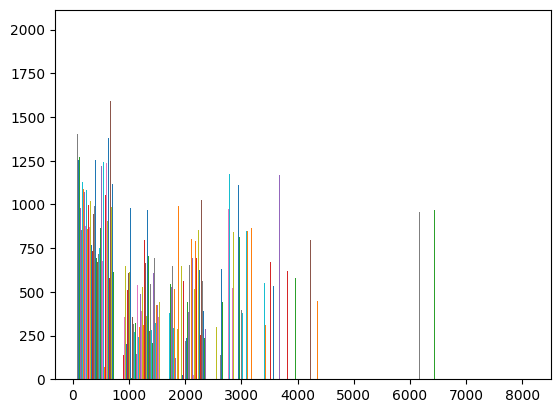

In [65]:
plt.hist(gamer.word_to_expected_len.values())

In [58]:
num_bins = 150
distrib_bins = np.quantile(np.array(list(gamer.word_to_expected_len.values())), np.linspace(0,1,num_bins))
#distrib_bins = np.histogram_bin_edges(np.array(list(gamer.word_to_expected_len.values())), bins="doane")
word_to_digitized_len = {}
for word,values in gamer.word_to_expected_len.items():
    word_to_digitized_len[word] = np.digitize(values, distrib_bins)

In [59]:
word_max_relation_mat = np.zeros((len(allowed_words), len(allowed_words))).astype(np.bool_)
for word1,values1 in tqdm(word_to_digitized_len.items()):
    idx1 = word_to_idx[word1]
    for word2,values2 in word_to_digitized_len.items():
        idx2 = word_to_idx[word2]
        if idx1 <= idx2:
            continue
        result = max_relation(values1, values2)
        word_max_relation_mat[idx1, idx2] = result
        word_max_relation_mat[idx2, idx1] = not result

100%|██████████████████████████████████████████████████████████████████████████████| 12970/12970 [23:03<00:00,  9.38it/s]


In [60]:
word_to_num_wins = {}
for word in allowed_words:
    word_idx = word_to_idx[word]
    word_to_num_wins[word] = word_max_relation_mat[word_idx, :].sum()

In [61]:
max_distrib_list = list(sorted(word_to_num_wins.items(), key=lambda x: x[1], reverse=True))
word_priority = list(sorted(word_to_num_wins, key=lambda x: word_to_num_wins[x], reverse=True))

In [96]:
with open("word_priority.list", "wb") as p:  # master list used for priorities in rollouts
    pickle.dump(word_priority, p)

In [62]:
with open("max_distrib_list.list", "wb") as p:  # master list used for priorities in rollouts
    pickle.dump(max_distrib_list, p)

In [64]:
max_distrib_list[:25]  # => changes the order a lot! gyppy still wins against every word (full implementation of easy mode)

[('gyppy', 12969),
 ('bluff', 12968),
 ('bobby', 12967),
 ('booby', 12966),
 ('boozy', 12965),
 ('buddy', 12964),
 ('buggy', 12963),
 ('chuck', 12961),
 ('civic', 12960),
 ('dizzy', 12959),
 ('chick', 12958),
 ('dummy', 12958),
 ('fizzy', 12957),
 ('fluff', 12956),
 ('fuzzy', 12954),
 ('foggy', 12953),
 ('gummy', 12950),
 ('guppy', 12949),
 ('humph', 12948),
 ('jiffy', 12947),
 ('jumpy', 12946),
 ('mamma', 12946),
 ('mimic', 12944),
 ('minim', 12943),
 ('goofy', 12942)]

In [41]:
max_distrib_list[:25]  # => changes the order a lot! gyppy wins against every word (INCLUDING double letter implem)

[('gyppy', 12969),
 ('bluff', 12968),
 ('bobby', 12967),
 ('booby', 12966),
 ('boozy', 12965),
 ('buddy', 12964),
 ('buggy', 12963),
 ('chuck', 12961),
 ('civic', 12960),
 ('dizzy', 12959),
 ('chick', 12957),
 ('dummy', 12957),
 ('fizzy', 12957),
 ('fluff', 12956),
 ('fuzzy', 12954),
 ('foggy', 12953),
 ('gummy', 12950),
 ('guppy', 12948),
 ('humph', 12948),
 ('jiffy', 12948),
 ('mamma', 12947),
 ('jumpy', 12946),
 ('mimic', 12944),
 ('minim', 12943),
 ('muddy', 12942)]

In [25]:
max_distrib_list[:25]  # => changes the order a lot! gyppy wins against every word (without double letter implem)

[('gyppy', 12969.0),
 ('bluff', 12968.0),
 ('bobby', 12967.0),
 ('booby', 12966.0),
 ('boozy', 12965.0),
 ('buddy', 12964.0),
 ('buggy', 12963.0),
 ('chuck', 12961.0),
 ('civic', 12960.0),
 ('dizzy', 12959.0),
 ('dummy', 12957.0),
 ('fizzy', 12957.0),
 ('fluff', 12956.0),
 ('chick', 12955.0),
 ('fuzzy', 12954.0),
 ('foggy', 12953.0),
 ('gummy', 12950.0),
 ('guppy', 12948.0),
 ('humph', 12948.0),
 ('jiffy', 12948.0),
 ('jumpy', 12946.0),
 ('mamma', 12946.0),
 ('mimic', 12944.0),
 ('minim', 12943.0),
 ('mummy', 12942.0)]

In [21]:
heuristic_list = list(sorted([(word,sum(size)) for word,size in gamer.word_to_expected_len.items()], key=lambda x: x[1], reverse=True))

In [22]:
heuristic_list[:25]  # with the more correct implementation of bounds

[('umphs', 27830741),
 ('imshi', 27736287),
 ('emmys', 27576198),
 ('ombus', 27263697),
 ('emyds', 27203668),
 ('hypha', 27180323),
 ('xysti', 27175894),
 ('onkus', 27149631),
 ('oshac', 27012008),
 ('oxbow', 27006363),
 ('uncus', 26984933),
 ('xysts', 26975655),
 ('kybos', 26961775),
 ('iglus', 26947722),
 ('incus', 26945905),
 ('gymps', 26931018),
 ('embus', 26918989),
 ('obeys', 26901075),
 ('ogham', 26885755),
 ('idyls', 26865484),
 ('ewhow', 26826246),
 ('mythi', 26777818),
 ('ogmic', 26759256),
 ('kynds', 26757393),
 ('odyls', 26717327)]

In [31]:
heuristic_list[:25]  # with the more correct implementation of double letters

[('qajaq', 13083328),
 ('immix', 12749511),
 ('xylyl', 12191947),
 ('fuffy', 12159670),
 ('gyppy', 12138766),
 ('zoppo', 11769814),
 ('jugum', 11767119),
 ('yukky', 11695859),
 ('cocco', 11657816),
 ('fuzzy', 11588095),
 ('hyphy', 11587432),
 ('jaffa', 11531839),
 ('bubby', 11392460),
 ('zocco', 11189489),
 ('kibbi', 11095059),
 ('kudzu', 11024599),
 ('boffo', 10987520),
 ('yummy', 10987166),
 ('vivid', 10967747),
 ('mummy', 10941769),
 ('buzzy', 10897783),
 ('oxbow', 10864021),
 ('jinni', 10841911),
 ('mamma', 10828095),
 ('civic', 10765086)]

In [20]:
heuristic_list[:25]  # => without mor "correct" implementation of double letters

[('qajaq', 13219438),
 ('immix', 12759128),
 ('xylyl', 12199829),
 ('fuffy', 12160646),
 ('gyppy', 12140401),
 ('zoppo', 11833770),
 ('jugum', 11770375),
 ('cocco', 11751144),
 ('yukky', 11699352),
 ('jaffa', 11643223),
 ('hyphy', 11591368),
 ('fuzzy', 11588095),
 ('bubby', 11392945),
 ('zocco', 11279801),
 ('kibbi', 11112431),
 ('boffo', 11053907),
 ('kudzu', 11029833),
 ('yummy', 10991950),
 ('vivid', 10982032),
 ('mummy', 10943493),
 ('oxbow', 10925794),
 ('mamma', 10923309),
 ('buzzy', 10897783),
 ('jinni', 10857660),
 ('jeeze', 10842336)]

In [86]:
class GreedyExpected():
    def __init__(self, num_rollouts=30):
        self.num_rollouts = num_rollouts
        self.reset()

    def reset(self):
        self.word_to_game_lens = {w: [] for w in allowed_words}
        self.explored = defaultdict(set)  # round -> tuple

    def rollout_game(self, game: AntiWordle, first_word):
        for word in game.remaining_words.iter_words(sparse=(game.round >= 2)):
            if word not in self.explored[(game.round, first_word, game.answer)]:
                break
        else:
            print("resorting to random from already explored")
            word = self.explored[(game.round, first_word, game.answer)].pop()  # pick some random element if we've already explored everything
        self.explored[(game.round, first_word, game.answer)].add(word)
        print(word in game.remaining_words)
        result = game.play_word(word)
        print(game.round, (word, first_word, game.answer), len(game.remaining_words))
        viable_words = game.remaining_words.all_words()
        print(viable_words[:min(25, len(viable_words))])
        if result > 0:
            print("game done, return =", game.round)
            return result
        return self.rollout_game(game, first_word)


    def explore(self, game):
        game.speculate()
        start_state = game.save_state()
        for potential_answer in tqdm(answer_words):
            game.answer = potential_answer
            for potential_guess in tqdm(allowed_words):
                if potential_guess not in game.remaining_words or potential_guess == potential_answer:
                    continue
                game.play_word(potential_guess) # we are now in a specific (answer, [first_word]) state
                state_now = game.save_state()
                for _ in range(self.num_rollouts): # num rollouts
                    print("hi")
                    self.word_to_game_lens[potential_guess].append(self.rollout_game(game, potential_guess))
                    game.restore_state(*state_now)
                game.restore_state(*start_state)
                break
            break
    def save_self(self):
        import pickle
        with open("distributions.dict", "wb") as p:
            pickle.dump(self.word_to_game_lens, p)
batched_game = AntiWordle(batched=True)
mc_gamer = GreedyExpected(num_rollouts=10)
mc_gamer.explore(batched_game)

  0%|                                                                                          | 0/12970 [00:00<?, ?it/s]

hi
True
2 ('bluff', 'gyppy', 'aback') 674
['bombo', 'kibbi', 'oxbow', 'zimbi', 'babka', 'abaka', 'abaca', 'bacca', 'combo', 'coomb', 'kabab', 'mamba', 'bizzo', 'dabba', 'bajan', 'bindi', 'ebbed', 'jibba', 'jembe', 'nimbi', 'bibbs', 'xebec', 'jibbs', 'zebec', 'aback']
False
3 ('ayaya', 'gyppy', 'aback') 8
['aback', 'aband', 'abaci', 'abask', 'abacs', 'abash', 'abate', 'abase']
True
4 ('aback', 'gyppy', 'aback') 8
['aback', 'aband', 'abaci', 'abask', 'abacs', 'abash', 'abate', 'abase']
game done, return = 4
hi
True
2 ('chuck', 'gyppy', 'aback') 40
['knock', 'klick', 'aback', 'knack', 'flick', 'flock', 'kiack', 'alack', 'block', 'flack', 'frock', 'wrick', 'fleck', 'black', 'brock', 'brick', 'wreck', 'frack', 'wrack', 'smock', 'brack', 'swack', 'snick', 'dreck', 'drack']
False
3 ('moody', 'gyppy', 'aback') 31
['klick', 'aback', 'knack', 'flick', 'kiack', 'alack', 'flack', 'wrick', 'fleck', 'black', 'brick', 'wreck', 'frack', 'wrack', 'brack', 'swack', 'snick', 'dreck', 'drack', 'stick', 't

  0%|                                                                                           | 0/2313 [00:01<?, ?it/s]

False
63 ('gunny', 'gyppy', 'aback') 157
['jaffa', 'qajaq', 'babka', 'abaka', 'abaca', 'bacca', 'kabab', 'tazza', 'taata', 'aflaj', 'falaj', 'walla', 'kacha', 'aback', 'batta', 'afara', 'hatha', 'zakat', 'calla', 'fatwa', 'halal', 'jhala', 'lahal', 'bacha', 'jacal']
False
64 ('gunny', 'gyppy', 'aback') 157
['jaffa', 'qajaq', 'babka', 'abaka', 'abaca', 'bacca', 'kabab', 'tazza', 'taata', 'aflaj', 'falaj', 'walla', 'kacha', 'aback', 'batta', 'afara', 'hatha', 'zakat', 'calla', 'fatwa', 'halal', 'jhala', 'lahal', 'bacha', 'jacal']
False
65 ('gunny', 'gyppy', 'aback') 157


KeyboardInterrupt: 

  0%|                                                                                           | 0/2313 [00:00<?, ?it/s]

In [12]:
class HumanStrategy():
    def __init__(self):
        self.reset()

    def reset(self):
        pass

    def guess(self, game):
        print(game)
        human = input("Guess word: ").lower()
        while human not in allowed_words:
            print(f"*{allowed_words[200]}*, #{human}#")
            print("Word is not in allowed word list")
            print(game)
            human = input("Guess word: ").lower()
        return human

In [13]:
def play_antiwordle(game, strategy):
    game.reset()
    result = game.CONTINUE
    while result < 0: # either CONTINUE or INVALID_WORD
        word_guess = strategy.guess(game)
        #print("Attempting guess of", word_guess)
        #print(game)
        result = game.play_word(word_guess)
        break
    return result

def evaluate_strategy(strategy, iterate=True, profile=False):
    total = 0
    game = AntiWordle()
    g_profiler.profile = profile
    if not iterate:
        looper = answer_words[:1]
    else:
        looper = answer_words
    for answer in tqdm(looper):
        strategy.reset()
        game.reset()
        game.answer = answer
        total += play_antiwordle(game, strategy)
        break
    print("Average number of rounds lasted:", total/len(answer_words))
    if profile:
        print(g_profiler)


In [72]:
# store important values
gamer_word_to_expected_len = gamer.word_to_expected_len # alias
word_max_relation_mat = word_max_relation_mat.astype(np.bool_)
%store gamer_word_to_expected_len word_to_num_wins word_max_relation_mat word_priority

Stored 'gamer_word_to_expected_len' (dict)
Stored 'word_to_num_wins' (dict)
Stored 'word_max_relation_mat' (ndarray)
Stored 'word_priority' (list)


In [11]:
# Restore all values
%store -r gamer_word_to_expected_len word_to_num_wins word_max_relation_mat word_priority

In [25]:
max(num_letters.items(), key=lambda x: max(x[1].items(), key=lambda y: y[1]))

('pzazz', Counter({'p': 1, 'z': 3, 'a': 1}))

In [100]:
human_game = AntiWordle(batched=False)
while True:
    for word in word_priority:
        if word in human_game.remaining_words:
            print("Best word:", word)
            break
    green_resp = input("Any new green letters (input as 'c0|r1|a2' or 'n' if none")
    green_updates = []
    if green_resp != "n":
        green_updates = [(x[0],int(x[1])) for x in green_resp.split("|")]
        print("rules submitted were", green_updates)
    print("If you know if there is >=1 b, type b>0, if there is <=1 b, type b<=1 (or b<1 => can type b<0 if no b's in the word)). Do a | separated list of such things")
    bounds_resp = input("Any new info on bounds (include greens) ('n' if none)?")
    lower_updates = {}
    upper_updates = {}
    if bounds_resp != "n":
        bound_rules = bounds_resp.split("|")
        for rule in bound_rules:
            if ">" in rule: # lower bound rule
                lower_updates[rule[0]] = int(rule[-1])
            if "<" in rule: # upper bound rule
                upper_updates[rule[0]] = int(rule[-1])
    human_game.remaining_words.update_list(green_updates, lower_updates, upper_updates, word, 0)

Best word: gyppy


Any new green letters (input as 'c0|r1|a2' or 'n' if none n


If you know if there is >=1 b, type b>0, if there is <=1 b, type b<=1 (or b<1 => can type b<0 if no b's in the word)). Do a | separated list of such things


Any new info on bounds (include greens) ('n' if none)? g<0|y<0|p<0


Best word: bluff


Any new green letters (input as 'c0|r1|a2' or 'n' if none n


If you know if there is >=1 b, type b>0, if there is <=1 b, type b<=1 (or b<1 => can type b<0 if no b's in the word)). Do a | separated list of such things


Any new info on bounds (include greens) ('n' if none)? b<0|l<0|f<0


Best word: chuck


Any new green letters (input as 'c0|r1|a2' or 'n' if none n


If you know if there is >=1 b, type b>0, if there is <=1 b, type b<=1 (or b<1 => can type b<0 if no b's in the word)). Do a | separated list of such things


Any new info on bounds (include greens) ('n' if none)? u<0


Best word: civic


Any new green letters (input as 'c0|r1|a2' or 'n' if none n


If you know if there is >=1 b, type b>0, if there is <=1 b, type b<=1 (or b<1 => can type b<0 if no b's in the word)). Do a | separated list of such things


Any new info on bounds (include greens) ('n' if none)? c<0|i<0|v<0


Best word: mamma


Any new green letters (input as 'c0|r1|a2' or 'n' if none m0


rules submitted were [('m', 0)]
If you know if there is >=1 b, type b>0, if there is <=1 b, type b<=1 (or b<1 => can type b<0 if no b's in the word)). Do a | separated list of such things


Any new info on bounds (include greens) ('n' if none)? a<0|m>0|m<=1


Best word: motto


Any new green letters (input as 'c0|r1|a2' or 'n' if none t2


rules submitted were [('t', 2)]
If you know if there is >=1 b, type b>0, if there is <=1 b, type b<=1 (or b<1 => can type b<0 if no b's in the word)). Do a | separated list of such things


Any new info on bounds (include greens) ('n' if none)? o<0|t>0|t<=1


Best word: meted


Any new green letters (input as 'c0|r1|a2' or 'n' if none e1|e3


rules submitted were [('e', 1), ('e', 3)]
If you know if there is >=1 b, type b>0, if there is <=1 b, type b<=1 (or b<1 => can type b<0 if no b's in the word)). Do a | separated list of such things


Any new info on bounds (include greens) ('n' if none)? e>1|d<0


Best word: meter


KeyboardInterrupt: Interrupted by user